In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sb

In [2]:
REGEX_WHITESPACE = re.compile(r'(\W|[0-9])+')
porter = PorterStemmer()
stop_words_set = set(stopwords.words('english'))


def text_normalize(text):
    if not text or pd.isnull(text):
        return ''
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    words = [w for w in words if len(str(w)) > 1]
    words = [w for w in words if not w in stop_words_set]
    words = [porter.stem(word) for word in words]
    new_text = ' '.join(words) 
    if not new_text or pd.isnull(new_text):
        return ''
    return new_text

In [3]:
df = pd.read_csv(r'clustering_reviews.csv', encoding='latin1')

In [4]:
df

,category,title,review1,review2,review3
0,tablets,Lenovo Tab M10 HD 10.1 Android Tablet (16GB),This tablet has major compatibility problems f...,I need a basic android tablet for my business ...,This thing is a pain in the ass to use. The po...
1,tablets,"CHUWI Hipad LTE Android 8.0 Tablet PC, 10.1 in...",i like the tablet a lot.. at time's its hard t...,Purchased this tablet for someone as a replace...,"Exactly as described ,very impressed with pack..."
2,tablets,"Certified Refurbished Fire HD 8 Tablet (8"" HD ...",After having an iPad mini for the past four ye...,did not come with google play services install...,Got this for my husband who has a fear of anyt...
3,air pumps,Swimline Electric Pump for Inflatables,"If you use as the directions tell you to do, t...","Loud, prone to having hoses detach, but it get...",I used this last weekend to fill 2 inflatable ...
4,air pumps,2 PCS Medical Grade Rubber Pump Air Blower For...,I used it to blow dust from my back camera bef...,Worked as described.,Does the job but with a really annoying squeak
5,air pumps,"EPAuto 12V DC Portable Air Compressor Pump, Di...","Ha! I love this little guy.\n\nWhen I say ""lit...",I purchased this to leave in my trunk for emer...,I'm a car guy and have dozens of these things....
6,clothing,Feetmat Men's Non Slip Mesh Sneakers Lightweig...,I tested this feetmat mens athletic shoes on ...,I have made the best decision by buying this s...,I like these simple yet uniquely styled shoes....
7,clothing,Calvin Klein Women's Classic Cashmere Wool Ble...,Perfect! I wanted something longer than a peac...,While many of the small details were present i...,"I loved this coat, but had to return it as the..."
8,clothing,adidas Boys' Tricot Jogger Pant,"My son is 57 inches 70 lbs , this is how they ...",My son only wears track pants or joggers.....e...,These are the cutest little pants\nThey look g...
9,plant seeds,TickleMe Plant Seeds Packets (2) for Party Bag...,"They were really easy to grow, I used 1 bag an...",Bought these for my niece and my nephew and ke...,Awesome.


In [5]:
df['all_reviews'] = df.apply(lambda x : ' '.join([x.review1, x.review2, x.review3]), axis=1)
df['all_reviews'] = df['all_reviews'].apply(lambda txt : re.sub(REGEX_WHITESPACE, ' ', txt))
df['all_reviews'] = df['all_reviews'].apply(lambda txt : text_normalize(txt))

df['normalized_title'] = df['title'].apply(lambda txt : re.sub(REGEX_WHITESPACE, ' ', txt))
df['normalized_title'] = df['normalized_title'].apply(lambda txt : text_normalize(txt))


In [6]:
df[['category', 'normalized_title', 'all_reviews']]

,category,normalized_title,all_reviews
0,tablets,lenovo tab hd android tablet gb,tablet major compat problem multipl app may an...
1,tablets,chuwi hipad lte android tablet pc inch unlock ...,like tablet lot time hard get back main window...
2,tablets,certifi refurbish fire hd tablet hd display gb...,ipad mini past four year keen tri less expens ...
3,air pumps,swimlin electr pump inflat,use direct tell excel littl air pump price lit...
4,air pumps,pc medic grade rubber pump air blower dri eyel...,use blow dust back camera replac len got rid d...
5,air pumps,epauto dc portabl air compressor pump digit ti...,ha love littl guy say littl guy mean affection...
6,clothing,feetmat men non slip mesh sneaker lightweight ...,test feetmat men athlet shoe road crush gravel...
7,clothing,calvin klein women classic cashmer wool blend ...,perfect want someth longer peacoat lb got size...
8,clothing,adida boy tricot jogger pant,son inch lb fit thin spring wear good athlet s...
9,plant seeds,ticklem plant seed packet parti bag christma s...,realli easi grow use bag put seed pot worri go...


In [7]:
df['all_reviews'][2]

'ipad mini past four year keen tri less expens tablet husband kindl fire pleas decid give amazon tablet tri moment unbox tablet skeptic first blemish touch screen strike one next previou owner washington post subscript still activ tablet delet devic cloud second could play game without told insuffici storag final batteri drain within hour even full night charg suffic say box tablet sent back amazon today come googl play servic instal download differ apk got husband fear anyth tech love set parent control prevent make brick spend hour play favorit card game good handl larg hand vibrant display endless game option experi refurb anyth posit except valu amz devic read full hous music qualiti good custom support'

In [8]:
tfidf_vectorizer = TfidfVectorizer(stop_words = list(stop_words_set), ngram_range = (1, 2), binary = False, 
                                   tokenizer = lambda s:s.split(' '), max_features = 10000, min_df = 1)

tf_idf_mat = tfidf_vectorizer.fit_transform(df['all_reviews'])
tf_idf_names = tfidf_vectorizer.get_feature_names()                               


C:\Users\yhoresh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
tf_idf_mat.shape

(12, 1956)

In [10]:
type(tf_idf_mat)

scipy.sparse.csr.csr_matrix

In [11]:
tf_idf_mat.toarray()

array([[0.04681014, 0.05450571, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [12]:
tf_idf_names[0:10]

['abl',
 'abl easili',
 'abl reach',
 'abl shut',
 'absolut',
 'absolut love',
 'activ',
 'activ tablet',
 'adapt',
 'adapt fit']

In [13]:
pd.DataFrame(tf_idf_mat.toarray(), columns = tf_idf_names)

,abl,abl easili,abl reach,abl shut,absolut,absolut love,activ,activ tablet,adapt,adapt fit,...,year,year keen,year old,year sinc,yet,yet plant,yet stylish,yet uniqu,zip,zip travel
0,0.046810,0.054506,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.078912,0.078912,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063726,0.063726,0.000000,0.000000,...,0.048345,0.063726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070376,0.070376,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.047813,0.000000,0.027837,0.027837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027837,0.027837
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.039703,0.000000,0.000000,0.052334,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050637,0.000000,0.000000,0.066747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.074157,0.000000,0.097751,0.000000,0.074157,0.000000,0.097751,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.054259,0.071522,0.000000,0.000000,0.000000,0.000000


In [14]:
# check reviews
tsne = TSNE(n_components = 2, perplexity=5)
X_embedded = tsne.fit_transform(tf_idf_mat.toarray())


C:\Users\yhoresh\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\yhoresh\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [15]:
X_embedded

array([[-6.1144497e+01,  3.3112067e+02],
       [-2.6310654e+02,  3.0403323e+02],
       [-1.6889316e+02,  3.7024207e+02],
       [-8.9627464e+01,  3.9430286e+01],
       [-2.1475304e+02, -3.1499997e-01],
       [-2.4401428e+01,  1.1817789e+02],
       [ 4.0875611e+00, -2.3604695e+02],
       [-2.1840141e+02, -3.0337521e+02],
       [-1.1582219e+02, -3.0030078e+02],
       [ 2.8025964e+02, -1.6836601e+02],
       [ 2.9682071e+02, -2.8503006e+01],
       [ 1.8215627e+02, -1.4489935e+02]], dtype=float32)

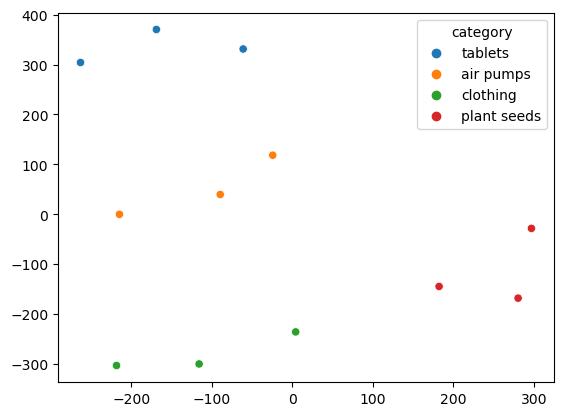

In [16]:
sb.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue = df['category'])
plt.show()

C:\Users\yhoresh\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\yhoresh\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


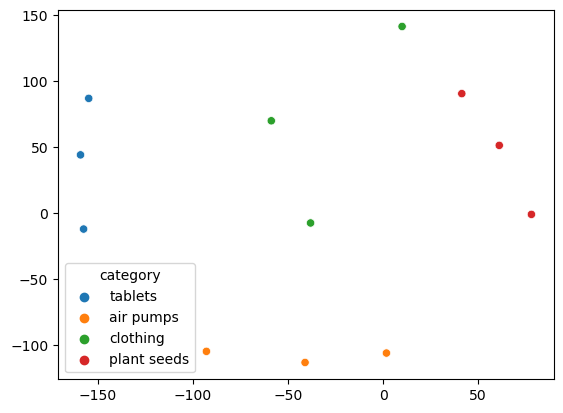

In [17]:
# check titles
tf_idf_mat = tfidf_vectorizer.fit_transform(df['normalized_title'])

tsne = TSNE(n_components = 2, perplexity=5)
X_embedded = tsne.fit_transform(tf_idf_mat.toarray())
sb.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue = df['category'])
plt.show()